# Лабораторная работа №1
Выполнила: *Девятерикова А.В.*  
группа: *М8О-401Б-18*  

Загрузим данные

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import leastsq
from scipy.optimize import fmin
import matplotlib.pyplot as plt

path = '~/Учёба/Семестр 7/САД/'
name = 'df1.csv'
df = pd.read_csv(path+name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5533 entries, 0 to 5532
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   5533 non-null   int64  
 1   Depthm       5533 non-null   int64  
 2   T_degC       5512 non-null   float64
 3   Salnty       5461 non-null   float64
 4   O2ml_L       5510 non-null   float64
 5   STheta       5453 non-null   float64
 6   O2Sat        5439 non-null   float64
 7   Oxy_µmol/Kg  5439 non-null   float64
 8   Phaeop       3439 non-null   float64
 9   PO4uM        5470 non-null   float64
 10  SiO3uM       5533 non-null   float64
 11  NO2uM        5258 non-null   float64
 12  NO3uM        5250 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 562.1 KB


Удалим лишние столбцы

In [2]:
df.drop(df.columns[[0]], axis=1, inplace=True)

Удалим строки, значения глубины в которых равняются нулю, для того чтобы было возможно построить обратную зависимость

In [3]:
df = df.loc[df['SiO3uM'] != 0.]

Построим корреляционную матрицу

In [4]:
df.corr()

,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg,Phaeop,PO4uM,SiO3uM,NO2uM,NO3uM
Depthm,1.000000,-0.639440,0.591439,-0.594977,0.636111,-0.598347,-0.593572,-0.232749,0.635225,0.841484,-0.183803,0.665742
T_degC,-0.639440,1.000000,-0.651658,0.842650,-0.976531,0.892910,0.844303,-0.007850,-0.907606,-0.839437,0.119248,-0.926013
Salnty,0.591439,-0.651658,1.000000,-0.867245,0.789675,-0.846160,-0.867329,-0.053136,0.845651,0.802367,-0.199661,0.856165
O2ml_L,-0.594977,0.842650,-0.867245,1.000000,-0.903449,0.993677,0.999999,0.176123,-0.977608,-0.891462,0.244259,-0.972832
STheta,0.636111,-0.976531,0.789675,-0.903449,1.000000,-0.940455,-0.903935,0.025986,0.948725,0.863244,-0.135641,0.957753
O2Sat,-0.598347,0.892910,-0.846160,0.993677,-0.940455,1.000000,0.993806,0.143058,-0.987284,-0.888055,0.221530,-0.985112
Oxy_µmol/Kg,-0.593572,0.844303,-0.867329,0.999999,-0.903935,0.993806,1.000000,0.185763,-0.978705,-0.892256,0.247547,-0.973360
Phaeop,-0.232749,-0.007850,-0.053136,0.176123,0.025986,0.143058,0.185763,1.000000,-0.079438,-0.102137,0.423776,-0.110807
PO4uM,0.635225,-0.907606,0.845651,-0.977608,0.948725,-0.987284,-0.978705,-0.079438,1.000000,0.913825,-0.195498,0.989959
SiO3uM,0.841484,-0.839437,0.802367,-0.891462,0.863244,-0.888055,-0.892256,-0.102137,0.913825,1.000000,-0.219638,0.912779


Построим график зависимости концентрации силикатов от глубины

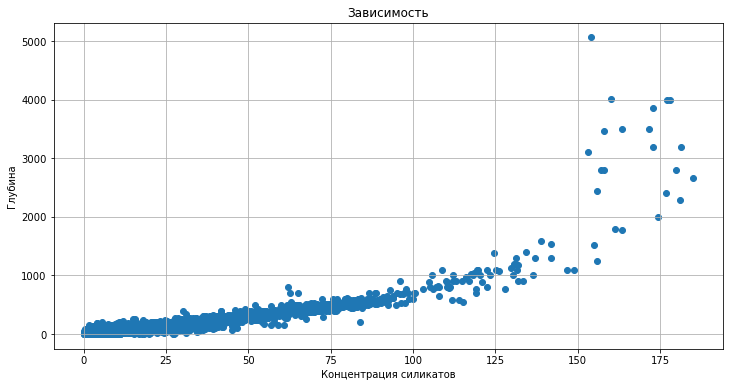

In [5]:
x = np.array(df.SiO3uM)
y = np.array(df.Depthm)

plt.figure(figsize=(12,6))
plt.scatter(x, y)
plt.gca().update(dict(title='Зависимость', xlabel='Концентрация силикатов', ylabel='Глубина'))
plt.grid()
plt.show()

#### Подберём нужную степень регрессии и оценим параметры с помощью МНК  

Напишем вспомогательные функции

In [6]:
X = np.linspace(np.min(x), np.max(x), df.shape[0])

def graph(Y, method):
    plt.figure(figsize=(12,6))
    plt.scatter(x, y)
    plt.plot(X, Y, color='black')
    plt.gca().update(dict(title=method, xlabel='Концентрация силикатов', ylabel='Глубина'))
    plt.grid()
    plt.show()
    
def polinom(theta, x):
    f = 0
    for i in range(len(theta)):
        f += theta[i] *  x ** i
    return f

theta = lambda n: [1] * n

rho = lambda theta: y - polinom(theta, x)

Функции для подсчёта коэффициента детерминации и оценки по МНК

In [7]:
def det(theta):
    e = y - polinom(theta, x)
    ss_res = np.sum(e ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    R = 1 - ss_res / ss_tot
    return R

def LS(n):
    theta_ls = leastsq(rho, theta(n))
    print('Оценка параметров:', theta_ls[0])
    graph(polinom(theta_ls[0], X), 'МНК')
    print('Коэффициент детерминации:', det(theta_ls[0]))

Линейная регрессия первой степени

Оценка параметров: [-28.25092076   7.74001403]


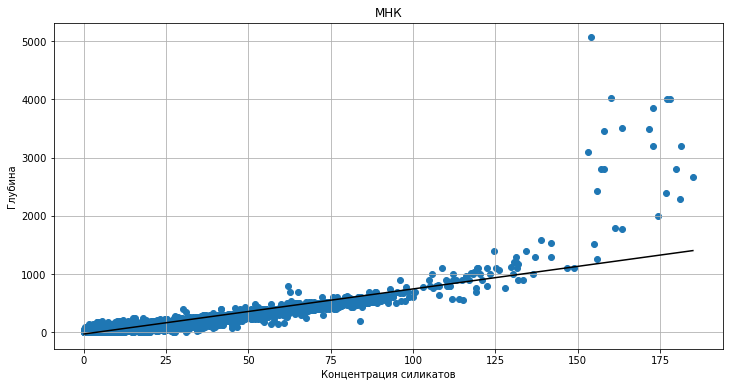

Коэффициент детерминации: 0.7080945803611453


In [8]:
LS(2)

Вторая степень

Оценка параметров: [52.22718581  0.19625291  0.08016394]


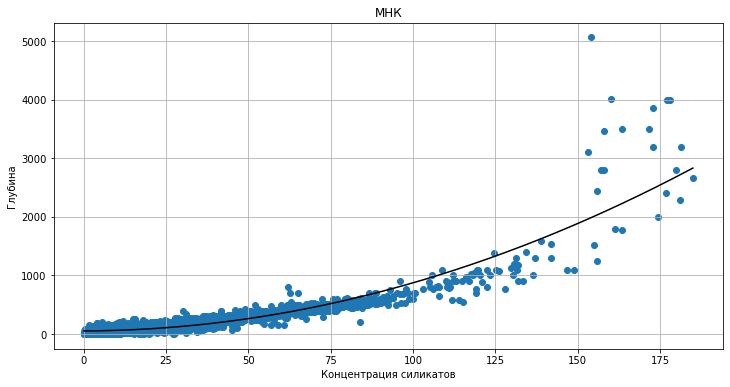

Коэффициент детерминации: 0.864775415862626


In [9]:
LS(3)

Третья степень

Оценка параметров: [ 1.29283342e+01  6.64073407e+00 -6.02464531e-02  6.82713364e-04]


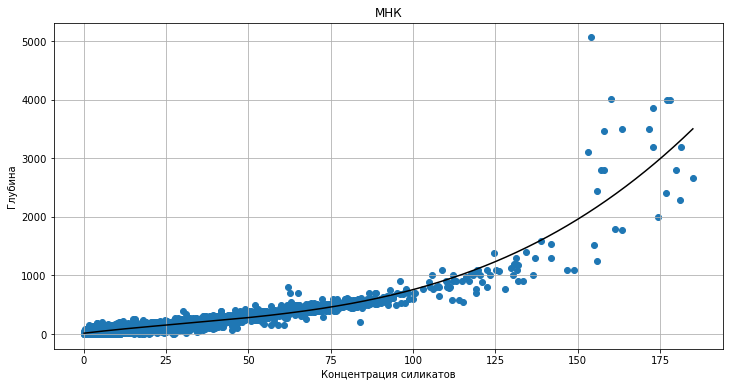

Коэффициент детерминации: 0.8931904870863725


In [10]:
LS(4)

Четвёртая степень

Оценка параметров: [ 2.30712704e+01  4.06444926e+00  3.80846651e-02 -4.66459373e-04
  3.90320339e-06]


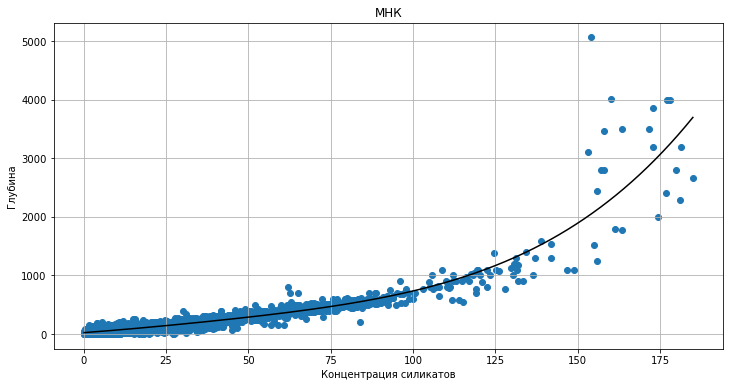

Коэффициент детерминации: 0.8949028644822299


In [11]:
LS(5)

Коэффициент детерминации вырос не сильно, значит останавливаемся на третьей степени

In [12]:
theta_ls = leastsq(rho, theta(4))

Получим оценки параметров с помощью функции Хьюбера и Тьюки

In [13]:
H = np.column_stack([np.ones(df.shape[0]), x, x ** 2, x ** 3])

def Huber(u, delta=100):
    return 0.5 * u ** 2 if abs(u) < delta else delta * (abs(u) - 0.5 * delta)   

def minHuber(theta, delta=10):
    return np.sum([Huber(yi - np.sum(theta * h), delta) for yi, h in zip(y, H)])

def Tukey(u, delta=1):
        return delta ** 2/6 * (1 - (1 - (u/delta) ** 2) ** 3) if abs(u) <= delta else delta ** 2/6

def minTukey(theta, delta=1):
    return np.sum([Tukey(yi - np.sum(theta * h), delta) for yi, h in zip(y,H)])


Optimization terminated successfully.
         Current function value: 1751571.906632
         Iterations: 154
         Function evaluations: 263
[ 1.07065159e+01  5.63268495e+00 -2.09878312e-02  3.68422281e-04]


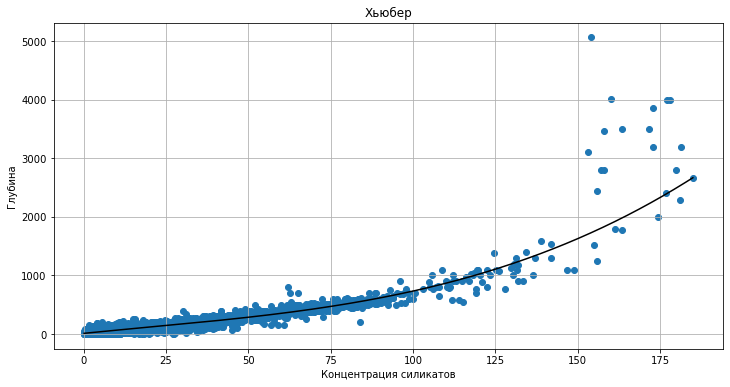

0.8687060735848048


In [14]:
theta_huber = fmin(minHuber, theta_ls[0])
print(theta_huber)
graph(polinom(theta_huber, X), 'Хьюбер')
print(det(theta_huber))

Optimization terminated successfully.
         Current function value: 905.814749
         Iterations: 173
         Function evaluations: 323
[ 1.36049882e+01  6.72969607e+00 -5.83164315e-02  6.93008829e-04]


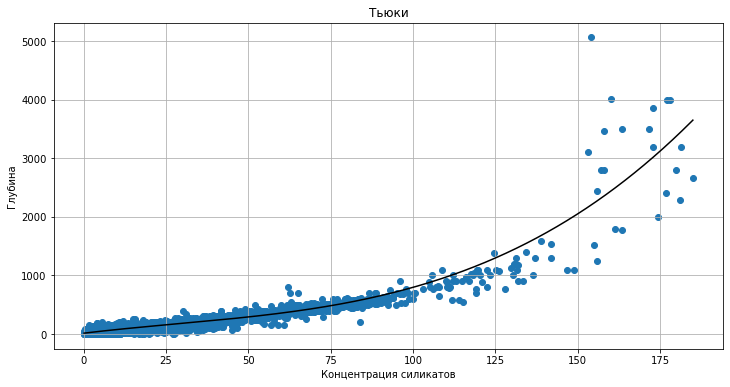

0.8903949749252511


In [15]:
theta_tukey = fmin(minTukey, theta_ls[0])
print(theta_tukey)
graph(polinom(theta_tukey, X), 'Тьюки')
print(det(theta_tukey))

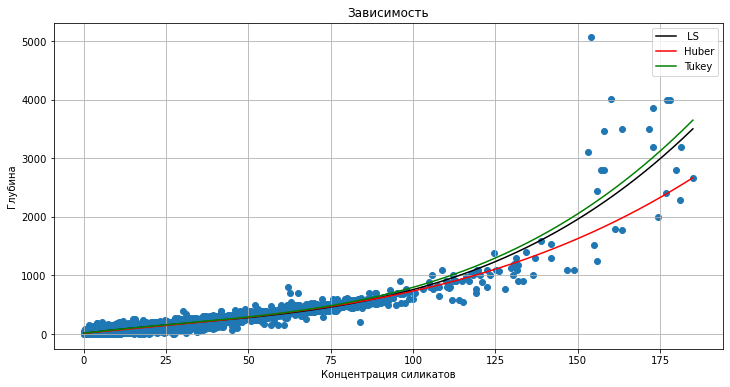

In [19]:
plt.figure(figsize=(12,6))
plt.scatter(x, y)
plt.plot(X, polinom(theta_ls[0], X), color='black', label=' LS')
plt.plot(X, polinom(theta_huber, X), color='red', label='Huber')
plt.plot(X, polinom(theta_tukey, X), color='green', label='Tukey')
plt.gca().update(dict(title='Зависимость', xlabel='Концентрация силикатов', ylabel='Глубина'))
plt.grid()
plt.legend()
plt.show()